Showing  24
Showing  24


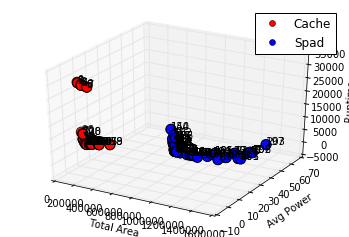

Showing  24
Showing  24


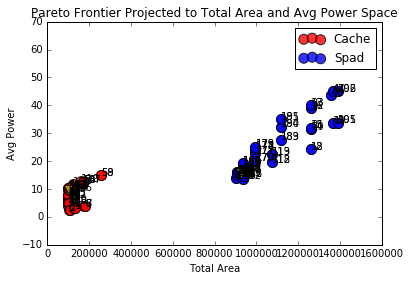

Showing  24
Showing  24


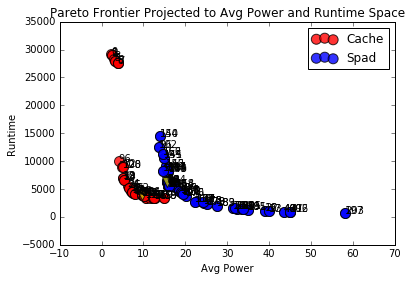

Showing  24
Showing  24


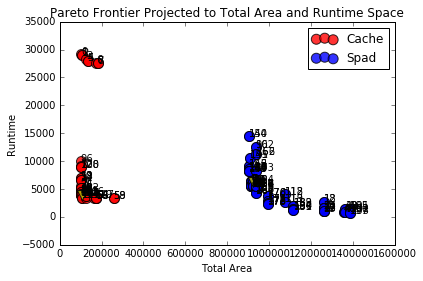

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def is_pareto_efficient(costs):
    """
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<=c, axis=1)  # Remove dominated points
    return is_efficient

# In[94]:
def get_pareto_points(files, outputs):
    brk_col = "Avg FU Dynamic Power"
    dfs = []

    for f in files:
        dfs.append(pd.read_csv(f, index_col=0))

    df = pd.concat(dfs)
    df.reset_index(drop=True, inplace=True)
    df.drop(['arrays','memory_type'], axis=1, inplace=True)
    inputs = df.columns.tolist()[:df.columns.tolist().index("Avg FU Dynamic Power")]
    df['Runtime'] = (df['Cycle '] * df.cycle_time).values / 1000 # Runtime in us
    input_data = df.loc[:,inputs]
    output_data = df.loc[:,outputs]
    dat = output_data.as_matrix()
    mask = is_pareto_efficient(dat)
    data = output_data[mask].sort_values(outputs)
    return data, mask




def plot_pareto3d(data, outputs, hold=False, color='r', label=None):
    global ax
    global labels
    X_LABEL = outputs[0]
    Y_LABEL = outputs[1]
    Z_LABEL = outputs[2]
    plt.xlabel(outputs[0])
    plt.ylabel(outputs[1])
    ax.set_zlabel(zlabel=outputs[2])
    x = data.loc[:,X_LABEL].values
    y = data.loc[:,Y_LABEL].values
    z = data.loc[:,Z_LABEL].values
    alphas = 0.8
    marker = 'o'
    ax.scatter(x,y,z,c=color, marker=marker,alpha = alphas, s=SIZE)
    v = 24
    if v in data.index:
        print("Showing ", v)
        ax.scatter(x[v],y[v], z[v],c='y', marker='v',alpha = alphas, s=SIZE)
    # ax.plot(x,y,z,c=color, marker=marker,alpha = alphas)
    if not label is None:
        lines.append( mpl.lines.Line2D([0],[0], linestyle="none", c=color, marker='o') )
        labels.append(label)
    for xv, yv, zv, l in zip(x, y, z, [str(x) for x in data.index.values.tolist()]):
        ax.text(xv, yv, zv, l)
    if hold:
        plt.hold(True)
    else:
        if not label is None:
            ax.legend(lines, labels, numpoints = 1)
        plt.show()



def plot_pareto2d(data, outputs, hold=False, color='r', label=None):
    global ax
    global labels
    X_LABEL = outputs[0]
    Y_LABEL = outputs[1]
    plt.xlabel(outputs[0])
    plt.ylabel(outputs[1])
    x = data.loc[:,X_LABEL].values
    y = data.loc[:,Y_LABEL].values
    ax.set_title("".join(["Pareto Frontier Projected to ",X_LABEL, " and ", Y_LABEL, " Space"]) )
    alphas = 0.8
    marker = 'o'
    # ax.plot(x,y,z,c=color, marker=marker,alpha = alphas)
    if not label is None:
        lines.append( ax.scatter(x,y,c=color, marker=marker,alpha = alphas, s=SIZE, label=label) )
        labels.append(label)
    else:
        ax.scatter(x,y,c=color, marker=marker,alpha = alphas, s=SIZE)
    v = 24
    if v in data.index:
        print("Showing ", v)
        ax.scatter(x[v],y[v],c='y', marker='v',alpha = alphas, s=SIZE)
    for xv, yv, l in zip(x, y, [str(x) for x in data.index.values.tolist()]):
        ax.text(xv, yv, l)
    if hold:
        plt.hold(True)
    else:
        if not label is None:
            ax.legend(lines, labels, numpoints = 1)
        plt.show()


SIZE = 100

fig = plt.figure()
ax = fig.gca(projection='3d')
lines = []
labels = []

files1 = ["smart_64x64_CACHE.csv", "64x64_CACHE_SMART_2.csv"]
files2 = ["64x64_SPAD.csv", "64x64_SPAD_2_block.csv", "64x64_SPAD_3_cyclic.csv"]
outputs = ["Total Area", "Avg Power", "Runtime"]


data1, _ = get_pareto_points(files1, outputs)
data2, _ = get_pareto_points(files2, outputs)
# plt.show()

plot_pareto3d(data1, outputs, hold=True, color='r', label='Cache')
plot_pareto3d(data2, outputs, hold=False, color='b', label='Spad')

# Do 2d plots:
fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(data1, outputs[:-1], hold=True, color='r', label='Cache')
plot_pareto2d(data2, outputs[:-1], hold=False, color='b', label='Spad')

fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(data1, outputs[1:], hold=True, color='r', label='Cache')
plot_pareto2d(data2, outputs[1:], hold=False, color='b', label='Spad')

fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(data1, outputs[::2], hold=True, color='r', label='Cache')
plot_pareto2d(data2, outputs[::2], hold=False, color='b', label='Spad')



In [6]:
data1.loc[24,:]
data1.loc[26,:]
data2.loc[164,:]
data2.loc[160,:]

Total Area    936028.0000
Avg Power         19.0355
Runtime         4384.3500
Name: 160, dtype: float64